In [1]:
import sys
sys.path.append("../") 

In [2]:
from __future__ import division

import argparse, time, logging, random, math

import numpy as np
import mxnet as mx

from mxnet import gluon, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.,1.)
])

In [4]:
num_gpus = 1
model_ctx = mx.gpu()

num_workers = 8
batch_size = 64 
train_data = gluon.data.DataLoader(
    gluon.data.vision.MNIST(train=True).transform_first(transform),
    batch_size=batch_size, shuffle=True, last_batch='discard', num_workers=num_workers)

val_data = gluon.data.DataLoader(
    gluon.data.vision.MNIST(train=False).transform_first(transform),
    batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [5]:
for X,y in train_data:
    print(X.shape)
    print(y.shape)
    break

(64, 1, 28, 28)
(64,)


In [6]:
model_ctx

gpu(0)

### Bayesian inference for MNIST

* [Stochastic Gradient Descent](#chapter1)
* [Stochastic Gradient Langevin Dynamics](#chapter2)
* [Bayes By Backprop](#chapter3)
* [Diagnostics](#chapter4)


# Stochastic Gradient Descent <a class="anchor" id="chapter1"></a>

In [7]:
import mxnet as mx
from mxnet import nd, autograd, gluon
hyper={'alpha':10.}
in_units=(28,28)
out_units=10

In [8]:
import mxnet as mx
from hamiltonian.inference.sgd import sgd
from hamiltonian.models.softmax import lenet

model=lenet(hyper,in_units,out_units,ctx=model_ctx)
inference=sgd(model,model.par,step_size=0.1,ctx=model_ctx)

In [9]:
import hamiltonian
import importlib

try:
    importlib.reload(hamiltonian.models.softmax)
    importlib.reload(hamiltonian.inference.sgd)
    importlib.reload(hamiltonian.inference.base)
    print('modules re-loaded')
except:
    print('no modules loaded yet')


modules re-loaded


In [10]:
par,loss=inference.fit(epochs=100,batch_size=batch_size,data_loader=train_data,verbose=True)

  1%|          | 1/100 [00:41<1:08:21, 41.43s/it]

loss: 2.6327


 11%|█         | 11/100 [07:14<1:02:14, 41.96s/it]

loss: 1.9729


 21%|██        | 21/100 [13:57<49:20, 37.47s/it]  

loss: 0.3759


 31%|███       | 31/100 [20:00<41:58, 36.51s/it]

loss: 0.3533


 41%|████      | 41/100 [25:54<34:35, 35.18s/it]

loss: 0.3413


 51%|█████     | 51/100 [31:45<28:48, 35.27s/it]

loss: 0.3353


 61%|██████    | 61/100 [37:38<23:01, 35.41s/it]

loss: 0.3316


 71%|███████   | 71/100 [43:28<17:00, 35.18s/it]

loss: 0.3295


 81%|████████  | 81/100 [49:22<11:13, 35.45s/it]

loss: 0.3281


 91%|█████████ | 91/100 [54:50<04:54, 32.76s/it]

loss: 0.3275


100%|██████████| 100/100 [59:45<00:00, 35.86s/it]


In [11]:
model.net.collect_params()

{'0.weight': Parameter (shape=(6, 1, 5, 5), dtype=<class 'numpy.float32'>),
 '0.bias': Parameter (shape=(6,), dtype=<class 'numpy.float32'>),
 '2.weight': Parameter (shape=(16, 6, 5, 5), dtype=<class 'numpy.float32'>),
 '2.bias': Parameter (shape=(16,), dtype=<class 'numpy.float32'>),
 '4.weight': Parameter (shape=(120, 400), dtype=float32),
 '4.bias': Parameter (shape=(120,), dtype=float32),
 '5.weight': Parameter (shape=(84, 120), dtype=float32),
 '5.bias': Parameter (shape=(84,), dtype=float32),
 '6.weight': Parameter (shape=(10, 84), dtype=float32),
 '6.bias': Parameter (shape=(10,), dtype=float32)}

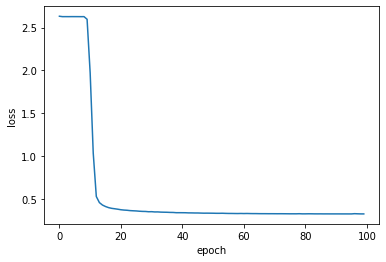

In [12]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [13]:
model.net.save_parameters('lenet_sgd_100_epochs.params')

In [9]:
model.net.load_parameters('lenet_sgd_100_epochs.params',ctx=model_ctx)
par=dict()
for name,gluon_par in model.net.collect_params().items():
    par.update({name:gluon_par.data()})

In [10]:
total_samples,total_labels=inference.predict(par,batch_size=batch_size,num_samples=10,data_loader=val_data)

In [11]:
y_hat=np.quantile(total_samples,.9,axis=0)

In [12]:
from sklearn.metrics import classification_report

print(classification_report(np.int32(total_labels),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       979
           1       1.00      0.99      0.99      1133
           2       0.99      0.99      0.99      1030
           3       1.00      0.99      0.99      1008
           4       0.99      0.99      0.99       980
           5       0.99      0.99      0.99       890
           6       0.99      0.99      0.99       956
           7       0.99      0.99      0.99      1027
           8       0.98      0.99      0.99       973
           9       0.98      0.99      0.99      1008

    accuracy                           0.99      9984
   macro avg       0.99      0.99      0.99      9984
weighted avg       0.99      0.99      0.99      9984



# Stochastic Gradient Langevin Dynamics <a class="anchor" id="chapter2"></a>

In [53]:
from hamiltonian.inference.sgld import sgld
from hamiltonian.models.softmax import lenet

model=lenet(hyper,in_units,out_units,ctx=model_ctx)
inference=sgld(model,model.par,step_size=0.1,ctx=model_ctx)

In [54]:
import hamiltonian
import importlib

try:
    importlib.reload(hamiltonian.models.softmax)
    importlib.reload(hamiltonian.inference.sgld)
    print('modules re-loaded')
except:
    print('no modules loaded yet')

modules re-loaded


In [55]:
loss,posterior_samples=inference.sample(epochs=100,batch_size=batch_size,
                             data_loader=train_data,
                             verbose=True)

 20%|██        | 1/5 [00:26<01:46, 26.58s/it]

loss: 3.3136


 40%|████      | 2/5 [00:52<01:18, 26.28s/it]

loss: 3.2489


 60%|██████    | 3/5 [01:18<00:52, 26.19s/it]

loss: 3.3245


 80%|████████  | 4/5 [01:44<00:26, 26.16s/it]

loss: 3.2147


100%|██████████| 5/5 [02:11<00:00, 26.26s/it]

loss: 3.2275


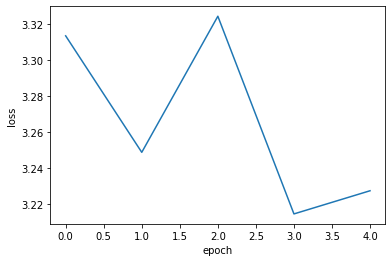

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 360
sns.set_style("whitegrid")


fig=plt.figure(figsize=[5,5])
plt.plot(loss[0],color='blue',lw=3)
plt.plot(loss[1],color='red',lw=3)
plt.xlabel('Epoch', size=18)
plt.ylabel('Loss', size=18)
plt.title('SGLD Lenet MNIST', size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()
plt.savefig('sgld_softmax.pdf', bbox_inches='tight')

In [ ]:
posterior_samples_flat=[item for sublist in posterior_samples for item in sublist]

In [58]:
total_samples,total_labels=inference.predict(posterior_samples_flat,5,data_loader=val_data)

In [59]:
from sklearn.metrics import classification_report
posterior_samples

y_hat=np.quantile(total_samples,.9,axis=0)

print(classification_report(np.int32(total_labels),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.00      0.00      0.00      1135
           2       0.20      0.01      0.02      1032
           3       0.11      0.02      0.03      1010
           4       0.13      0.07      0.09       982
           5       0.07      0.08      0.08       892
           6       0.10      0.17      0.13       958
           7       0.12      0.35      0.18      1028
           8       0.11      0.34      0.16       974
           9       0.11      0.06      0.08      1009

    accuracy                           0.11     10000
   macro avg       0.09      0.11      0.07     10000
weighted avg       0.09      0.11      0.07     10000



# Bayes by Backprop <a class="anchor" id="chapter3"></a>

In [ ]:
par={'weights':nd.random_normal(shape=(num_inputs,num_outputs),ctx=model_ctx),
     'bias':nd.random_normal(shape=num_outputs,ctx=model_ctx)}
hyper={'alpha':10.}

In [ ]:
from hamiltonian.inference.bbb import bbb
from hamiltonian.models.softmax import softmax

model=mlp_softmax(hyper,in_units,out_units,4,32,ctx=model_ctx)
inference=bbb(model,model.par,step_size=0.05,ctx=model_ctx)

In [ ]:
import importlib
import hamiltonian
importlib.reload(hamiltonian.models.softmax)
importlib.reload(hamiltonian.inference.bbb)

In [ ]:
par,loss,(means,sigmas)=inference.fit(epochs=10,batch_size=64,
                             X_train=X_train,y_train=y_train,
                             verbose=False)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import mxnet.gluon.probability as mxp

def softplus(x):
    return nd.log(1. + nd.exp(x))

posterior=dict()
for var in par.keys():
    variational_posterior=mxp.normal.Normal(loc=means[var],
                                            scale=softplus(sigmas[var]))
    posterior.update({var:variational_posterior})
    
samples=[]
for _ in range(100):
    post_par=dict()
    for var in par.keys():
        post_par.update({var:posterior[var].sample().as_nd_ndarray()})
    y_pred=model.predict(post_par,nd.array(X_test,ctx=model_ctx))
    samples.append(y_pred.sample().asnumpy())
samples=np.asarray(samples)
y_hat=np.quantile(samples,.5,axis=0)

print(classification_report(np.int32(y_test),np.int32(y_hat)))

# Posterior Diagnostics <a class="anchor" id="chapter4"></a>

In [ ]:
import arviz as az

In [ ]:
np.expand_dims(np.asarray([posterior_samples['0.bias'][0].asnumpy() for sample in posterior_samples['0.bias']]),0).shape

In [ ]:
posterior_samples_numpy=dict()

for var in posterior_samples.keys():
    posterior_samples_numpy.update(
        {var:np.expand_dims(np.asarray(
            [sample.asnumpy() for sample in posterior_samples[var]]),0)
        })


In [ ]:
posterior_samples_numpy['0-weights'].shape

In [ ]:
dataset = az.convert_to_inference_data(posterior_samples_numpy)

In [ ]:
ess=az.ess(dataset)

In [ ]:
ess

In [ ]:
az.summary(dataset)

In [ ]:
784*10+10